In [1]:
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# py3helpers
from py3helpers.utils import merge_lists, list_dir
from py3helpers.multiprocess import (FAILURE_KEY, MEM_USAGE_KEY, TOTAL_KEY,
                                     BasicService, current_process,
                                     run_service)

# signalalign
from signalalign.fast5 import Fast5
from signalalign.hiddenMarkovModel import read_in_alignment_file

# Other common libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
# built in library
import os


In [2]:
def get_max_events(events2, start, stop):
    events = []
    for x in range(start, stop):
        pos_data = events2[events2["reference_index"] == x]
        if len(pos_data) > 0:
            index = events2[events2["reference_index"] == x].posterior_probability.idxmax()
            events.append(events2.loc[index]["descaled_event_mean"])
        else:
            break
    if len(events) == stop-start:
        return pd.Series(events)
    return None

In [3]:
def resegment(segment):
    data = []
    total_length = 0
    prev_index = 0
    prev_start = 0
    for i, row in segment.iterrows():
        if prev_index != row.reference_index:
            total_length = row.raw_start - prev_start
            if prev_start != 0:
                data.append((prev_start, total_length, prev_index))
            prev_start = row.raw_start
            prev_index = row.reference_index
    segment_events = pd.DataFrame(data, columns=["raw_start", "raw_length", "reference_index"])
    return segment_events

In [4]:
class BasicService(object):

    def __init__(self, function, n, service_name="example_service"):
        self.function = function
        self.n = n
        self.service_name = service_name

    def run(self, work_queue, done_queue):

        """
        Service used by the multiprocess module for an example of what should be created for multiprocessing
        :param work_queue: arguments to be done
        :param done_queue: errors and returns to be put
        :param service_name: name of the service
        """
        # prep
        total_handled = 0
        failure_count = 0
        count = 0
        # catch overall exceptions
        try:
            for f in iter(work_queue.get, 'STOP'):
                # catch exceptions on each element
                try:
                    return_value = self.function(**f)
                    if return_value is not None:
                        done_queue.put(return_value)
                        count += 1
                except Exception as e:
                    # get error and log it
                    message = "{}:{}".format(type(e), str(e))
                    error = "{} '{}' failed with: {}".format(self.service_name, current_process().name, message)
                    print("[{}] ".format(self.service_name) + error)
                    done_queue.put(error)
                    failure_count += 1

                # increment total handling
                total_handled += 1
                if count >= self.n:
                    break
                    
        except Exception as e:
            # get error and log it
            message = "{}:{}".format(type(e), str(e))
            error = "{} '{}' critically failed with: {}".format(self.service_name, current_process().name, message)
            print("[{}] ".format(self.service_name) + error)
            done_queue.put(error)

        finally:
            # logging and final reporting
            print("[%s] '%s' completed %d calls with %d failures"
                  % (self.service_name, current_process().name, total_handled, failure_count))
            done_queue.put("{}:{}".format(TOTAL_KEY, total_handled))
            done_queue.put("{}:{}".format(FAILURE_KEY, failure_count))


In [5]:
def multiprocess_get_25S_events(files, start, stop, n, worker_count=8):
    args = {"start": start, "stop": stop}
    service = BasicService(get_25s_event, n=n//worker_count, service_name="multiprocess_get_25S_events")
    total, failure, messages, output = run_service(service.run, files,
                                                   args, ["file"], worker_count=worker_count)
#     data = merge_lists(output)
    return pd.DataFrame(output, columns=list(range(start, stop))) 

In [6]:
def get_25s_event(file, start, stop):
    try:
        fh = Fast5(file)
        sam = fh.get_signalalign_events(sam=True).split("\t")
        contig = sam[2]
        sam_start = int(sam[3])
        if contig != "RDN25-1" or sam_start > start:
            return None

        raw = next(fh.get_reads(raw=True))
        scaler = StandardScaler()
        raw_tmp = scaler.fit_transform(raw.reshape(-1, 1))
        raw = raw_tmp.reshape(1, -1)[0]
        events = pd.DataFrame(fh.get_signalalign_events(mea=True))
        events2 = pd.DataFrame(fh.get_signalalign_events())

        segment = events[(events["reference_index"] >= start) & (events["reference_index"] <= stop)]
        new_events = resegment(segment)

        if len(new_events) != (stop-start):
            return None


        def get_mean(start, length):
            return np.mean(raw[start:start+length])

        def get_event_mean(raw_start):
            data = events2[events2["raw_start"] == raw_start]
        #     print(raw_start, data)
            if len(data) > 0: 
                return data.iloc[0].descaled_event_mean
            return None

    #         means = new_events.apply(lambda row: get_event_mean(row.raw_start), axis=1)[::-1]
        means = new_events.apply(lambda row: get_mean(row["raw_start"], row["raw_length"]), axis=1)[::-1]
    #         means = get_max_events(events2, start, stop)
        return means.values
    except:
        return None

In [7]:
def get_25S_events(files, start, stop, n):
    data = []
    total = 0
    for file in files:
        try:
            means = get_25s_event(file, start, stop)
            if means is None:
                continue
            data.append(means)
            total += 1
            if total >= n:
                break
        except:
            continue
        

    return pd.DataFrame(data, columns=list(range(start+1, stop+1))) 

In [8]:
wt_path = "figures/event_clustering/wt_embed"
wt_files = list_dir(wt_path, ext="fast5")

dbp3_path = "figures/event_clustering/dbp3_embed"
dbp3_files = list_dir(dbp3_path, ext="fast5")

prp43_path = "figures/event_clustering/prp43_embed"
prp43_files = list_dir(prp43_path, ext="fast5")

pxr1_path = "figures/event_clustering/pxr1_embed"
pxr1_files = list_dir(pxr1_path, ext="fast5")

ivt_path = "figures/event_clustering/ivt_embed"
ivt_files = list_dir(ivt_path, ext="fast5")

cbf5glu_path = "figures/event_clustering/cbf5glu_embed"
cbf5glu_files = list_dir(cbf5glu_path, ext="fast5")

nop58glu_path = "figures/event_clustering/nop58glu_embed"
nop58glu_files = list_dir(nop58glu_path, ext="fast5")



In [ ]:
# start = 2413
# stop = 2424



In [109]:

start = 2914
stop = 2930


# start = 1430
# stop = 1455

n = 395
wt_df = multiprocess_get_25S_events(wt_files, start=start, stop=stop, n=n)
wt_df["label"] = "wt"

pxr1_df = multiprocess_get_25S_events(pxr1_files, start=start, stop=stop, n=n)
pxr1_df["label"] = "pxr1"

prp43_df = multiprocess_get_25S_events(prp43_files, start=start, stop=stop, n=n)
prp43_df["label"] = "prp43"

dbp3_df = multiprocess_get_25S_events(dbp3_files, start=start, stop=stop, n=n)
dbp3_df["label"] = "dbp3"

ivt_df = multiprocess_get_25S_events(ivt_files, start=start, stop=stop, n=n)
ivt_df["label"] = "ivt"

cbf5glu_df = multiprocess_get_25S_events(cbf5glu_files, start=start, stop=stop, n=n)
cbf5glu_df["label"] = "cbf5glu"

nop58glu_df = multiprocess_get_25S_events(nop58glu_files, start=start, stop=stop, n=n)
nop58glu_df["label"] = "nop58glu"





[run_service] running service <bound method BasicService.run of <__main__.BasicService object at 0x1a33676518>> with 8 workers
[multiprocess_get_25S_events] 'Process-613' completed 153 calls with 0 failures
[multiprocess_get_25S_events] 'Process-616' completed 196 calls with 0 failures
[multiprocess_get_25S_events] 'Process-615' completed 237 calls with 0 failures
[multiprocess_get_25S_events] 'Process-618' completed 190 calls with 0 failures
[multiprocess_get_25S_events] 'Process-614' completed 216 calls with 0 failures
[multiprocess_get_25S_events] 'Process-617' completed 217 calls with 0 failures
[multiprocess_get_25S_events] 'Process-620' completed 181 calls with 0 failures
[multiprocess_get_25S_events] 'Process-619' completed 215 calls with 0 failures
[run_service] Completed in 4.977408854989335 seconds.
[run_service] Summary <bound method BasicService.run of <__main__.BasicService object at 0x1a33676518>>:
[run_service]	Time: 0.0 days 0.0 hr 0.0 min 4.0 sec
[run_service]	Total: 1

In [113]:
experiments = ["wt", "ivt", "cbf5glu", "nop58glu", "dbp3", "prp43", "pxr1",]
# experiment_dfs = [wt_df, ivt_df, cbf5glu_df, nop58glu_df, dbp3_df, prp43_df, pxr1_df]
experiments = ["nop58glu", "cbf5glu", "wt", "ivt"]

# df = nop58glu_df
df = pd.concat([nop58glu_df, cbf5glu_df, ivt_df, wt_df], ignore_index=True)
# df = pd.concat([wt_df, cbf5glu_df, ivt_df], ignore_index=True)
# df = pd.concat([wt_df, nop58glu_df, ivt_df], ignore_index=True)
# df = pd.concat([wt_df], ignore_index=True)

# cmap = "bwr"
# cmap = "jet"
# cmap = "coolwarm"
X = df.loc[:, df.columns != 'label']
scaled_X = X
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

scaled_X.rename(columns={x:x+3 for x in X.columns}, inplace=True)

In [117]:
figure_path = f'figures/event_clustering/event_clustering_{start}_{stop}_all.png'
figure_path = f'figures/event_clustering/event_clustering_{start}_{stop}_short_all.png'
# figure_path = f'figures/event_clustering/event_clustering_{start}_{stop}_short_cbf5.png'
# figure_path = f'figures/event_clustering/event_clustering_{start}_{stop}_cbf5.png'
# figure_path = f'figures/event_clustering/event_clustering_{start}_{stop}_short_nop58.png'
# figure_path = f'figures/event_clustering/event_clustering_{start}_{stop}_nop58.png'

# figure_path = None


<IPython.core.display.Javascript object>


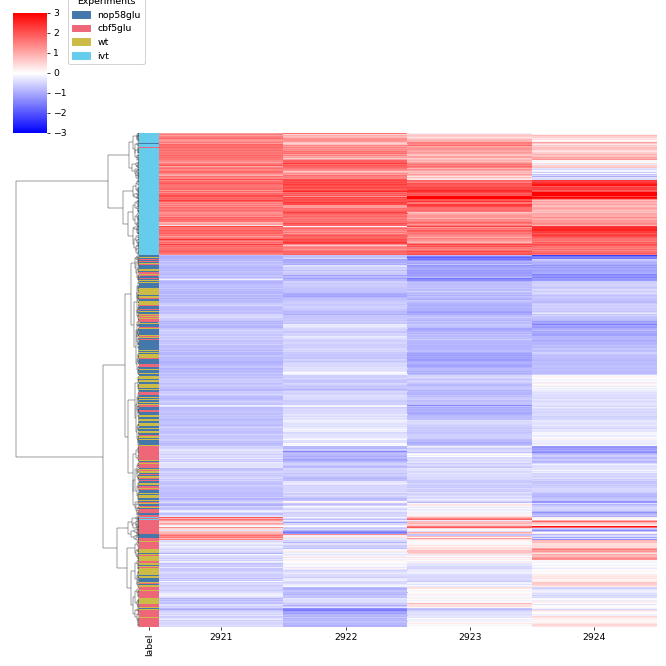

In [118]:
%matplotlib notebook
color_map = dict(zip(experiments, sns.color_palette("Set1")))
color_map = dict(zip(experiments, ['#4477AA', '#EE6677', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']))
row_colors = pd.DataFrame(df["label"].map(color_map))
g = sns.clustermap(scaled_X[list(range(2921, 2925))], method="ward", metric="euclidean", col_cluster=False,
                   row_cluster=True, row_colors=row_colors,
                   yticklabels=False, xticklabels=True, cmap=cmap, figsize=(10,10), 
                   vmin=-3, vmax=3)
# g = sns.clustermap(scaled_X[list(range(1448, 1451))], method="ward", metric="euclidean", col_cluster=False,
#                    row_cluster=True, row_colors=row_colors,
#                    yticklabels=False, xticklabels=True, cmap=cmap, figsize=(10,10), 
#                    vmin=-3, vmax=3)
# g = sns.clustermap(scaled_X, method="ward", metric="euclidean", col_cluster=False,
#                    row_cluster=True, row_colors=row_colors,
#                    yticklabels=False, xticklabels=True, cmap=cmap, figsize=(10,10), 
#                    vmin=-3, vmax=3)

experiment_labels = []
for experiment, color in color_map.items():
    red_patch = mpatches.Patch(color=color, label=experiment)
    experiment_labels.append(red_patch)

# red_pseudoU = mpatches.Patch(color="red", label="Pseudouridine")
# blue_twoprime = mpatches.Patch(color="blue", label="2'O methylcytosine")

first_legend = plt.legend(handles=experiment_labels, bbox_to_anchor=(1.5, 1.2), loc='upper left', ncol=1,
                          title="Experiments")
plt.gca().add_artist(first_legend)

if figure_path is not None:
    plt.savefig(figure_path, dpi=300)
else:
    plt.show()


<IPython.core.display.Javascript object>


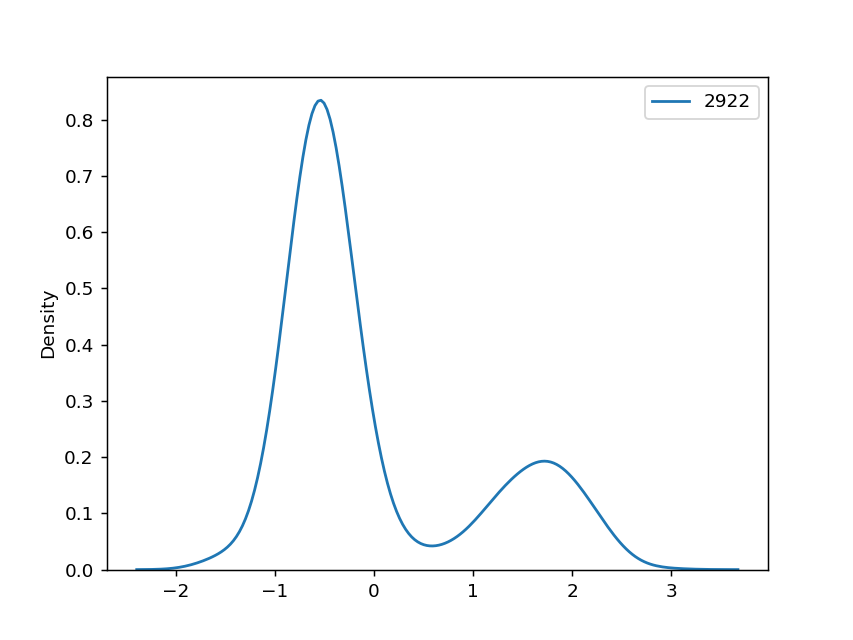

In [75]:
%matplotlib notebook

# g = sns.kdeplot(data=scaled_X[[1450]])
g = sns.kdeplot(data=scaled_X[[2922]])

plt.show()
